In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
import os
import re
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(tf.__version__)

1.12.0


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Load IMDB dataset

In [4]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the Imdb movie reviews sentiment analysis dataset.
    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.
    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)
    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015
        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [5]:
(train_data,train_labels),(test_data,test_labels) = load_imdb_sentiment_analysis_dataset(data_path="./data/")

### Data Exploration

In [6]:
# number of classes
set(train_labels)

{0, 1}

In [7]:
# get number of words per sample
num_words = [len(s.split()) for s in train_data]
print(np.median(num_words))

174.0


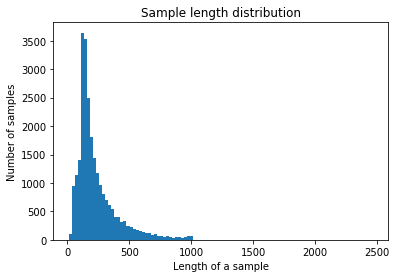

In [8]:
# plot sample length distribution
plt.hist([len(s.split()) for s in train_data], 100)
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [9]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [14]:
print(train_data[1])

The long list of "big" names in this flick (including the ubiquitous John Mills) didn't bowl me over to the extent that I couldn't judge the film on its actual merits. It is FULL of stereotypes, caricatures, and standard, set scenes, from the humble air-ace hero to the loud-mouthed yank flyer. The music track was such that at one point, about an hour before the end, I thought the film was over: loud, rising crescendo, grand flourish and finish then silence, but then the movie continued! I found no real storyline, haphazard writing, but smartly-pressed uniforms and the pretty Jean Simmons (pre-nose job) with a rousing little ditty. I cannot say that this picture has any of the ingredients which make a film great. I found it maudlin, mawkish and minor.


In [16]:
print(train_labels[1])

0


In [17]:
print(train_data[2])

Bette Midler showcases her talents and beauty in "Diva Las Vegas". I am thrilled that I taped it and I am able to view whenever I want to. She possesses what it takes to keep an audience in captivity. Her voice is as beautiful as ever and will truly impress you. The highlight of the show was her singing "Stay With Me" from her 1979 movie "The Rose". You can feel the emotion in the song and will end up having goose bumps. The show will leave you with the urge to go out and either rent a Bette Midler movie or go to the nearest music store and purchase one of Bette Midler's albums.


In [18]:
print(train_labels[2])

1


### Remove HTML tags

In [19]:
def preprocess(raw_text):
    # remove html tags
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', raw_text)
    # remove non-words
    #pattern = r'[^a-zA-Z0-9\s]'
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern,"",str(text))
    #text = "<START> " + text + " <END>"
    return text

In [20]:
train_data = list(map(lambda x:preprocess(x),train_data))
test_data = list(map(lambda x:preprocess(x),test_data))

In [21]:
train_data[1]

'The long list of big names in this flick including the ubiquitous John Mills didnt bowl me over to the extent that I couldnt judge the film on its actual merits It is FULL of stereotypes caricatures and standard set scenes from the humble airace hero to the loudmouthed yank flyer The music track was such that at one point about an hour before the end I thought the film was over loud rising crescendo grand flourish and finish then silence but then the movie continued I found no real storyline haphazard writing but smartlypressed uniforms and the pretty Jean Simmons prenose job with a rousing little ditty I cannot say that this picture has any of the ingredients which make a film great I found it maudlin mawkish and minor'

# Model Selection

In [13]:
# 1. Calculate the number of samples/number of words per sample ratio.
# 2. If this ratio is less than 1500, tokenize the text as n-grams and use a
#    simple multi-layer perceptron (MLP) model to classify them (left branch in the
#    flowchart below):
#      a. Split the samples into word n-grams; convert the n-grams into vectors.
#      b. Score the importance of the vectors and then select the top 20K using the scores.
#      c. Build an MLP model.
# 3. If the ratio is greater than 1500, tokenize the text as sequences and use a
#    CNN model to classify them (right branch in the flowchart below):
#      a. Split the samples into words; select the top 20K words based on their frequency.
#      b. Convert the samples into word sequence vectors.
#      c. If the original number of samples/number of words per sample ratio is less
#         than 15K, using a fine-tuned pre-trained embedding with the CNN
#         model will likely provide the best results.
# 4. Measure the model performance with different hyperparameter values to find
#    the best model configuration for the dataset.

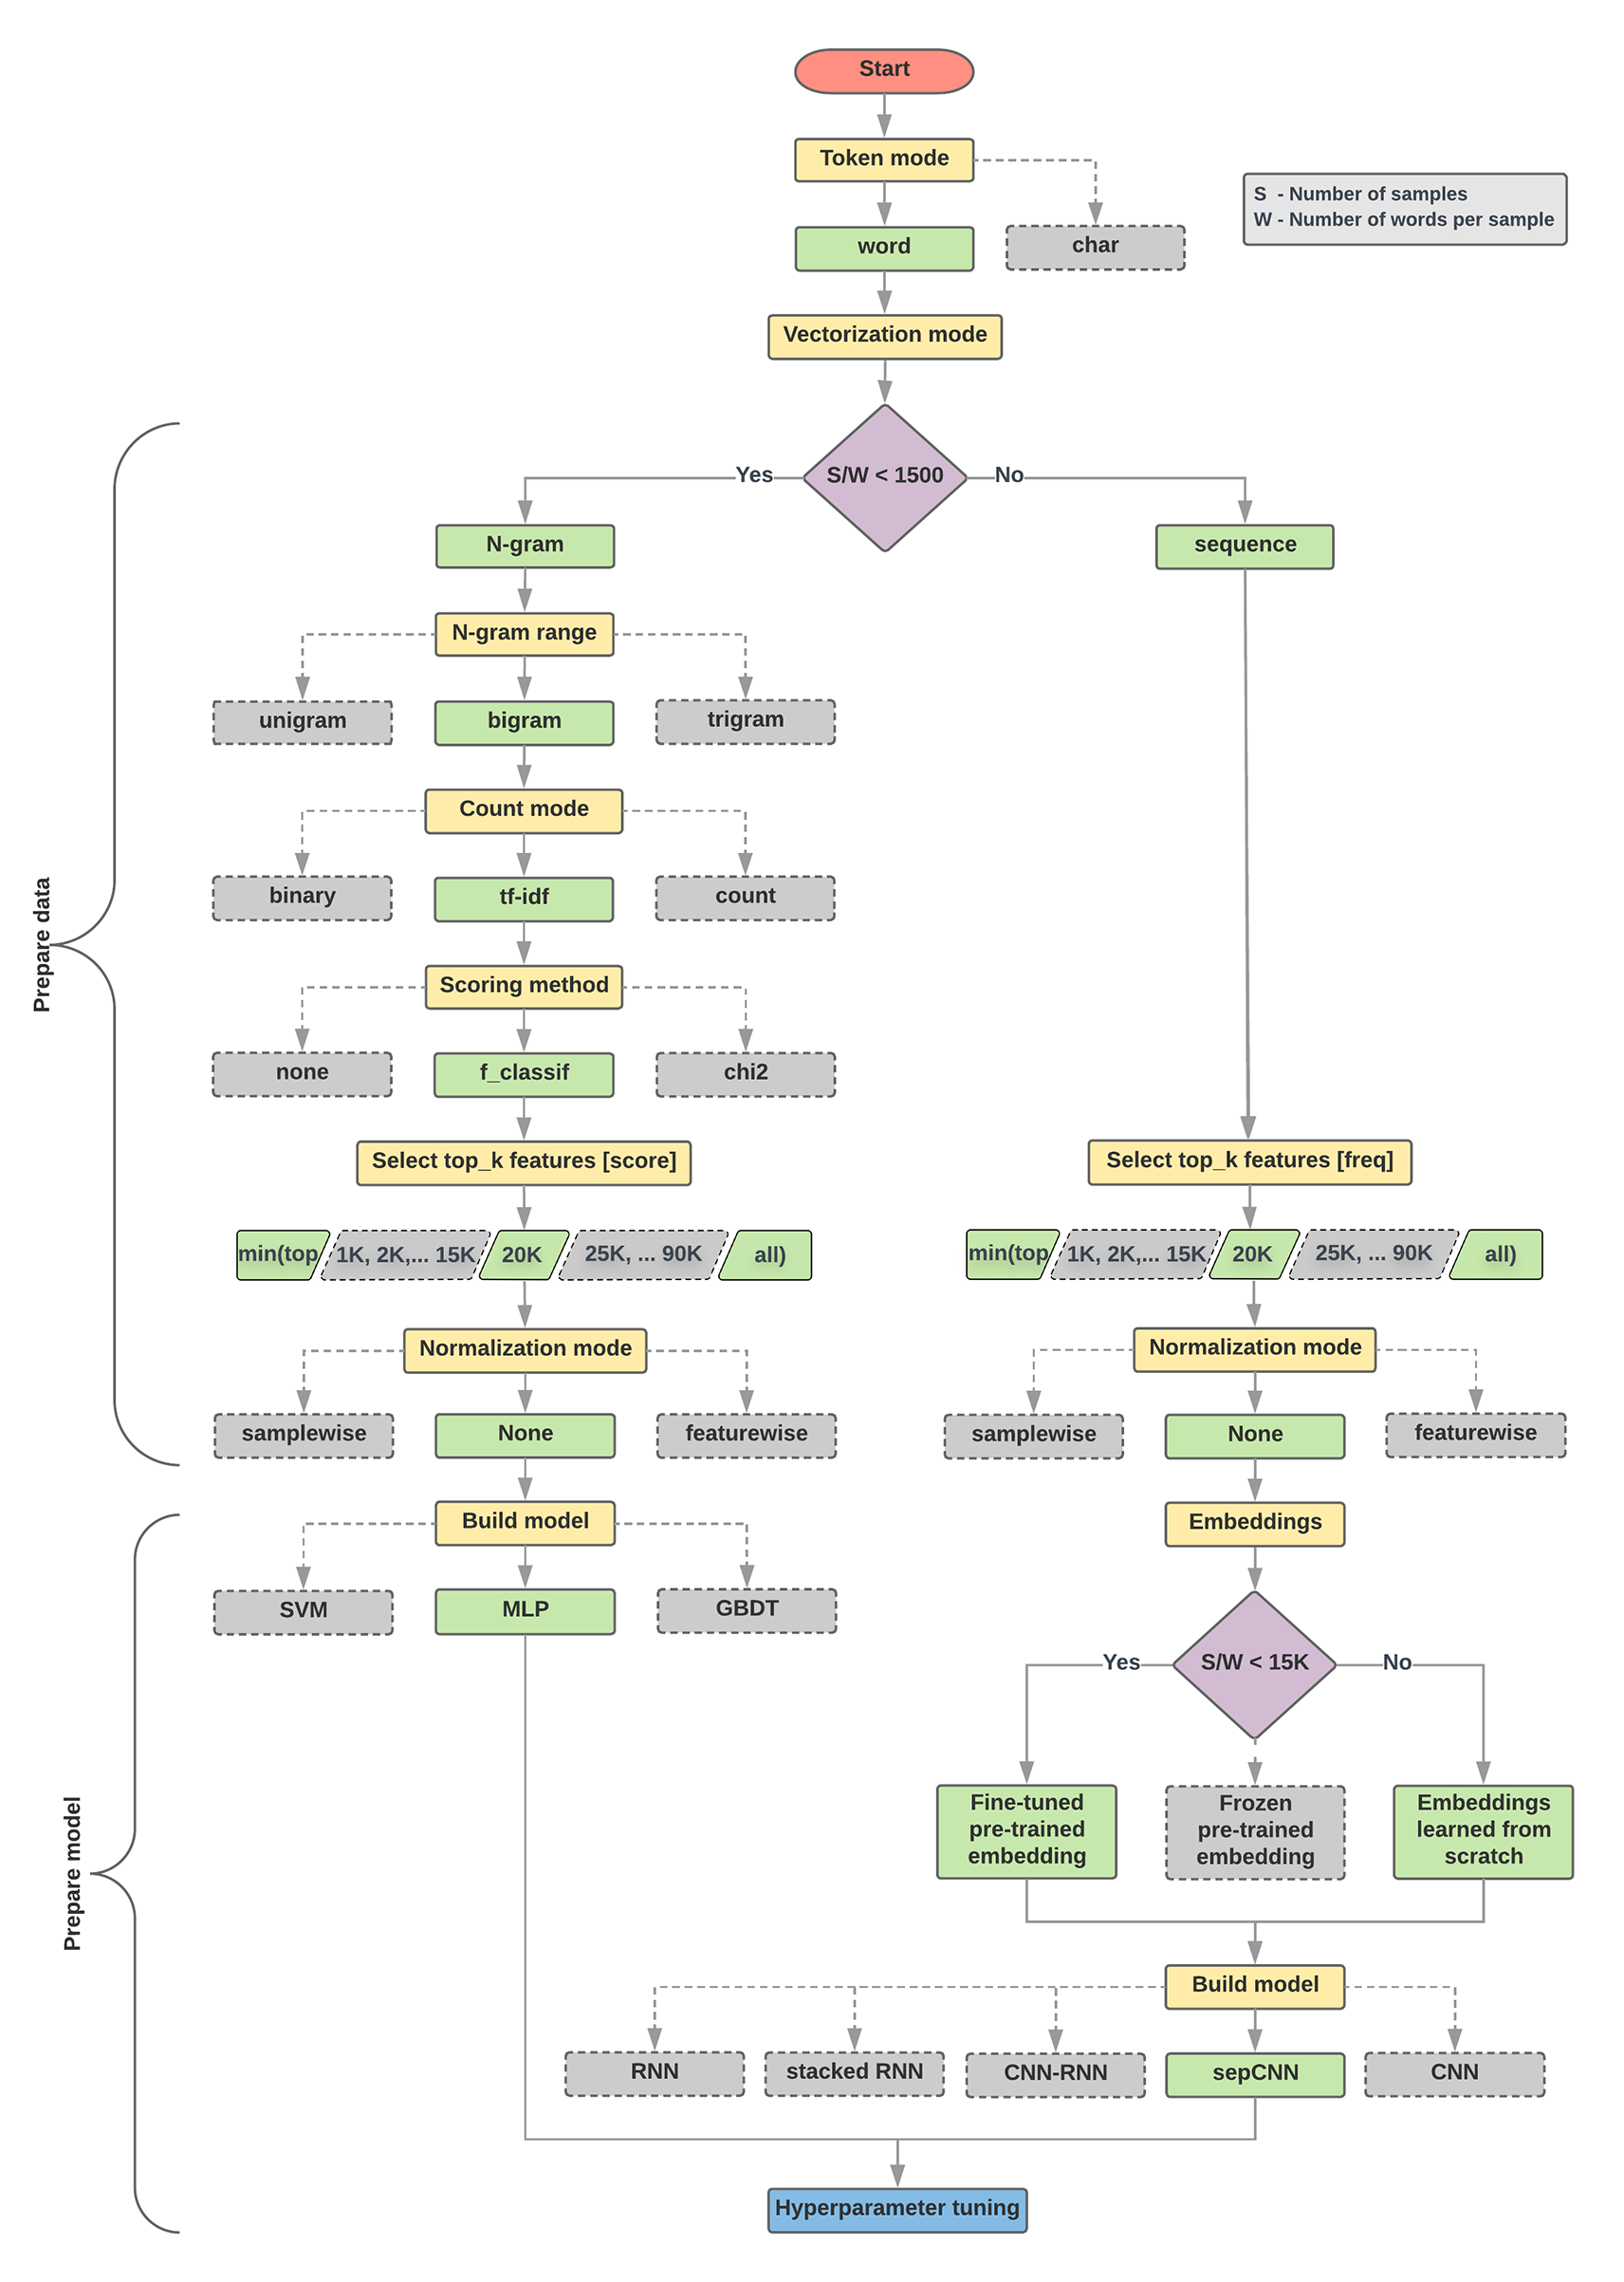

In [22]:
from IPython.display import Image
Image(filename='data/images/TextClassificationFlowchart.png')

## N-gram Vectorization [ OPTION A ]

In [16]:
# 1. Tokenize text samples into word uni+bigrams,
# 2. Vectorize using tf-idf encoding,
# 3. Select only the top 20,000 features from the vector of tokens by discarding tokens that 
#    appear fewer than 2 times and using f_classif to calculate feature importance.

In [23]:
def ngram_vectorize(train_texts, train_labels, val_texts, TOP_K = 3000):
    """Vectorizes texts as ngram vectors.
    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': (1, 2),  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 2,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val

In [24]:
x_train, x_val = ngram_vectorize(train_data, train_labels, test_data)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1567: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [25]:
x_train.shape

(25000, 3000)

In [26]:
# MLP (Multi-layer perceptron model)
#
# binary classification
op_units = 1
op_activation = 'sigmoid'
learning_rate = 1e-3
# multi-class classification
#op_units = num of classes
#activation = 'softmax'

model = models.Sequential()
model.add(Dropout(rate=0.2, input_shape=x_train.shape[1:]))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=op_units, activation=op_activation))

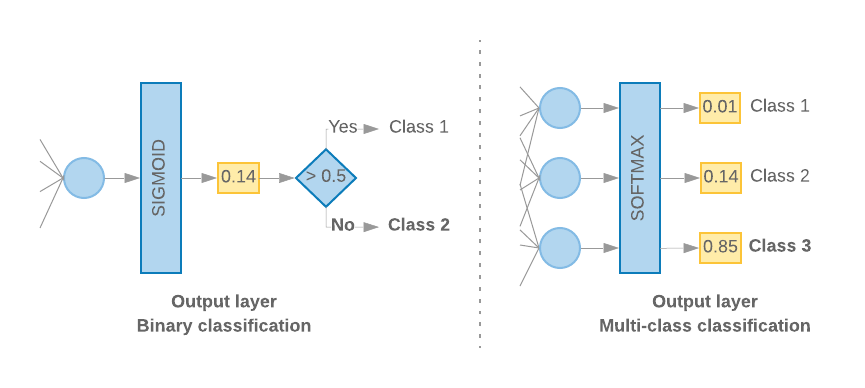

In [71]:
Image(filename='data/images/LastLayer.png')

In [27]:
# loss for binary classification
loss = 'binary_crossentropy'
# loss for multi-class classification
#loss = 'sparse_categorical_crossentropy'

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

In [28]:
# Train and validate model.
# With n-gram vector representation, we discard a lot of information about word order and grammar 
# (at best, we can maintain some partial ordering information when n > 1). 
# This is called a bag-of-words approach. 
# This representation is used in conjunction with models that don’t take ordering into account, 
# such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    #callbacks=callbacks,
                    validation_data=(x_val, y_val),
                    verbose=1,  # Logs once per epoch.
                    batch_size=128)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 5s 308us/step - loss: 0.5888 - acc: 0.8134 - val_loss: 0.4583 - val_acc: 0.8669
Epoch 2/40
15000/15000 [==============================] - 3s 224us/step - loss: 0.3862 - acc: 0.8667 - val_loss: 0.3274 - val_acc: 0.8871
Epoch 3/40
15000/15000 [==============================] - 3s 228us/step - loss: 0.3035 - acc: 0.8846 - val_loss: 0.2794 - val_acc: 0.8957
Epoch 4/40
15000/15000 [==============================] - 4s 235us/step - loss: 0.2688 - acc: 0.8899 - val_loss: 0.2576 - val_acc: 0.9017
Epoch 5/40
15000/15000 [==============================] - 3s 230us/step - loss: 0.2475 - acc: 0.9010 - val_loss: 0.2457 - val_acc: 0.9040
Epoch 6/40
15000/15000 [==============================] - 4s 236us/step - loss: 0.2334 - acc: 0.9053 - val_loss: 0.2386 - val_acc: 0.9052
Epoch 7/40
15000/15000 [==============================] - 4s 236us/step - loss: 0.2234 - acc: 0.9075 - val_loss: 0.2351 - 

In [35]:
# Print results.
#history = history.history
#print('Validation accuracy: {acc}, loss: {loss}'.format(
#        acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

In [34]:
results = model.evaluate(x_val,y_val)
print(results)

10000/10000 [==============================] - 1s 52us/step
[0.2553800339579582, 0.897]


In [25]:
# Save model.
model.save('./archive/saved_models/imdb_mlp_model.h5')

## Sequence Vectorization [ OPTION B ]

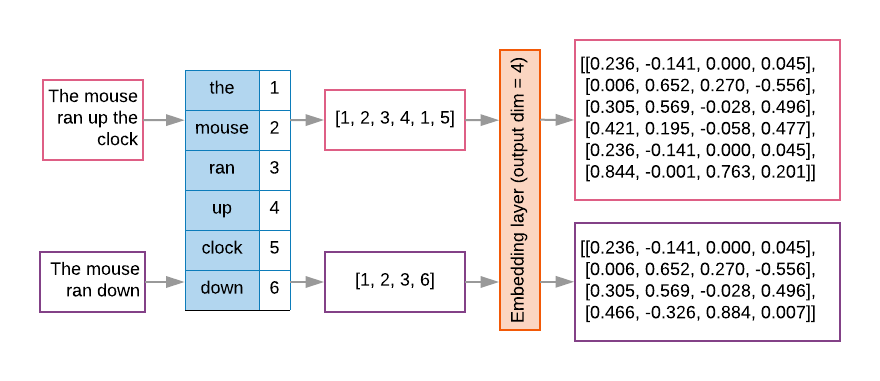

In [26]:
# We refer to models that can learn from the adjacency of tokens as sequence models. 
# This includes CNN and RNN classes of models. Data is pre-processed as sequence vectors for these models.
Image(filename='data/images/EmbeddingLayer.png')

In [36]:
# For some text samples, word order is critical to the text’s meaning. 
# For example, the sentences, “I used to hate my commute. My new bike changed that completely” can be understood 
# only when read in order. Models such as CNNs/RNNs can infer meaning from the order of words in a sample. 
# For these models, we represent the text as a sequence of tokens, preserving order.
#
# 1. Tokenizes the texts into words
# 2. Creates a vocabulary using the top 20,000 tokens
# 3. Converts the tokens into sequence vectors
# 4. Pads the sequences to a fixed sequence length
#
def sequence_vectorize(train_texts, val_texts, TOP_K = 3000, MAX_SEQUENCE_LENGTH = 256):
    """Vectorizes texts as sequence vectors.
    1 text = 1 sequence vector with fixed length.
    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.
    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    #max_length = len(max(x_train, key=len))
    #if max_length > MAX_SEQUENCE_LENGTH:
    #    max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    #
    # 1. Convert the arrays into vectors of 0s and 1s indicating word occurrence, 
    #    similar to a one-hot encoding. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. 
    #    Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. 
    #    This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.
    # 2. Alternatively, we can pad the arrays so they all have the same length,
    #    then create an integer tensor of shape max_length * num_reviews. 
    #    We can use an embedding layer capable of handling this shape as the first layer in our network.
    #
    x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH,padding="post")
    x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH,padding="post")
    return x_train, x_val, tokenizer.word_index

In [37]:
(x_train,x_test,wordIndx) = sequence_vectorize(train_data,test_data,3000,256)

In [38]:
type(wordIndx)
#109160

dict

In [39]:
wordIndx["first"]

84

In [40]:
print(x_train[3])

[  83   16   50    9  209    8   24    5  129   27    4   54  494   91
    4   30   58    9  209    8   37  206    7    1  726    2  182    1
  288   13    9  182  890    2  209    8  171    9 1654   11    1   16
    6  858 1044    5   91   11   22  621   48   10    6  155    9  377
  732   12  623    7    1   16    2    1  217   15    1  518 1916    3
  109   59    6   83   76    1  199    4   85    1   16  261    6    3
  313   93    4  521   28   37   87  199    4    3   16   17   76    3
  109  973   59    6    3   51  313 1185    9   37    1   16  433   36
    9  192    8    3  123    3   48   14   68    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [41]:
len(x_train[0]), len(x_train[1])

(256, 256)

### Convert the integers back to words

In [42]:
# It may be useful to know how to convert integers back to text. Here, 
# we'll create a helper function to query a dictionary object that contains the integer to string mapping
# A dictionary mapping words to an integer index
#word_index = imdb.get_word_index()

# The first indices are reserved
#word_index = {k:(v+3) for k,v in word_index.items()} 
#word_index["<PAD>"] = 0
#word_index["<START>"] = 1
#word_index["<UNK>"] = 2  # unknown
#word_index["<UNUSED>"] = 3

#reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

#def decode_review(idxs):
#    return ' '.join([reverse_word_index.get(i,'?') for i in idxs])

Indxword = dict([(value,key) for (key,value) in wordIndx.items()])

In [43]:
Indxword[1000]

'box'

### Build the model

In [51]:
# The neural network is created by stacking layers—this requires two main architectural decisions:
#
# 1. How many layers to use in the model?
# 2. How many hidden units to use for each layer?
#
# In this example, the input data consists of an array of word-indices. 
# The labels to predict are either 0 or 1. Let's build a model for this problem:

# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 3000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
#model.summary()

# Words in a given dataset are most likely not unique to that dataset. 
# We can thus learn the relationship between the words in our dataset using other dataset(s). 
# To do so, we can transfer an embedding learned from another dataset into our embedding layer. 
# These embeddings are referred to as pre-trained embeddings
# 
# There are pre-trained embeddings available that have been trained using large corpora, such as GloVe. 
# GloVe has been trained on multiple corpora (primarily Wikipedia)

In [52]:
# The layers are stacked sequentially to build the classifier:

# The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
# Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
# This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
# The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [53]:
# Create a validation set
# When training, we want to check the accuracy of the model on data it hasn't seen before. 
# Create a validation set by setting apart 10,000 examples from the original training data. 
# (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### Train the model

In [54]:
# Train the model for 40 epochs in mini-batches of 512 samples. 
# This is 40 iterations over all samples in the x_train and y_train tensors. 
# While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val,y_val),
                    verbose=1)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 3s 230us/step - loss: 0.6923 - acc: 0.5417 - val_loss: 0.6907 - val_acc: 0.6595
Epoch 2/40
15000/15000 [==============================] - 2s 163us/step - loss: 0.6879 - acc: 0.7031 - val_loss: 0.6839 - val_acc: 0.7115
Epoch 3/40
15000/15000 [==============================] - 2s 155us/step - loss: 0.6774 - acc: 0.7297 - val_loss: 0.6692 - val_acc: 0.7396
Epoch 4/40
15000/15000 [==============================] - 2s 154us/step - loss: 0.6575 - acc: 0.7593 - val_loss: 0.6445 - val_acc: 0.7475
Epoch 5/40
15000/15000 [==============================] - 2s 154us/step - loss: 0.6276 - acc: 0.7736 - val_loss: 0.6104 - val_acc: 0.7711
Epoch 6/40
15000/15000 [==============================] - 2s 154us/step - loss: 0.5897 - acc: 0.7888 - val_loss: 0.5713 - val_acc: 0.7905
Epoch 7/40
15000/15000 [==============================] - 2s 153us/step - loss: 0.5477 - acc: 0.8053 - val_loss: 0.5315 - 

### Evaluate the model

In [56]:
results = model.evaluate(x_test,test_labels)
print(results)

25000/25000 [==============================] - 1s 44us/step
[0.31911743265628817, 0.86872]


### Create a graph of accuracy and loss over time

In [57]:
# model.fit() returns a History object that contains a dictionary with everything that happened during training
# There are four entries: 
# one for each monitored metric during training and validation. 
# We can use these to plot the training and validation loss for comparison, 
# as well as the training and validation accuracy:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [59]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

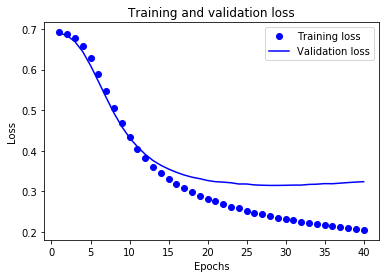

In [60]:
epochs = range(1,len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

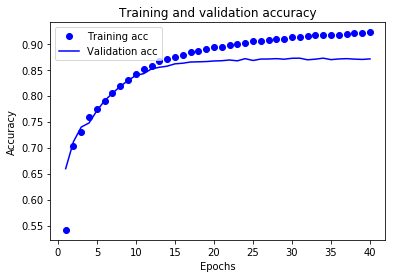

In [61]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# In this plot, the dots represent the training loss and accuracy, 
# and the solid lines are the validation loss and accuracy.
#
# Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. 
# This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
#
# This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. 
# This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. 
# After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

## Convolution Neural Networks (CNNs) Model  [ OPTION C ]

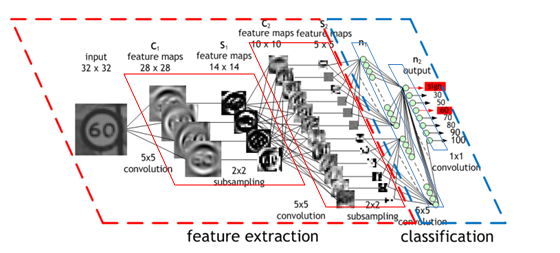

In [62]:
Image(filename='data/images/convolutional_neural_network.png')

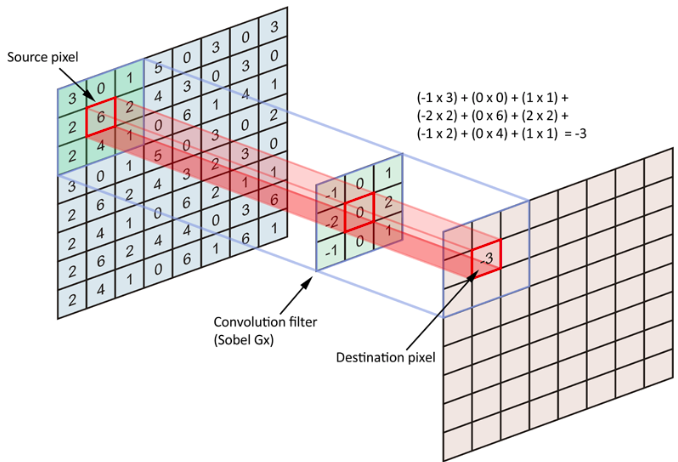

In [63]:
Image(filename='data/images/conv_filter.png')

In [64]:
vocab_size = 3000

model = keras.Sequential()
model.add(Embedding(vocab_size, 16, input_length=256))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

In [65]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [66]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [67]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks=callbacks_list,
                    validation_data=(x_val,y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 9s 597us/step - loss: 0.6905 - acc: 0.5323 - val_loss: 0.6756 - val_acc: 0.5895
Epoch 2/40
15000/15000 [==============================] - 8s 508us/step - loss: 0.5364 - acc: 0.7435 - val_loss: 0.3980 - val_acc: 0.8276
Epoch 3/40
15000/15000 [==============================] - 8s 507us/step - loss: 0.3155 - acc: 0.8705 - val_loss: 0.3374 - val_acc: 0.8593
Epoch 4/40
15000/15000 [==============================] - 8s 504us/step - loss: 0.2475 - acc: 0.9005 - val_loss: 0.3346 - val_acc: 0.8635
Epoch 5/40
15000/15000 [==============================] - 8s 506us/step - loss: 0.2156 - acc: 0.9147 - val_loss: 0.3339 - val_acc: 0.8687
Epoch 6/40
15000/15000 [==============================] - 8s 516us/step - loss: 0.1823 - acc: 0.9293 - val_loss: 0.3439 - val_acc: 0.8695
Epoch 7/40
15000/15000 [==============================] - 8s 519us/step - loss: 0.1604 - acc: 0.9406 - val_loss: 0.3657 - 

In [68]:
results = model.evaluate(x_test,test_labels)
print(results)

25000/25000 [==============================] - 3s 129us/step
[0.36038728952884674, 0.859]


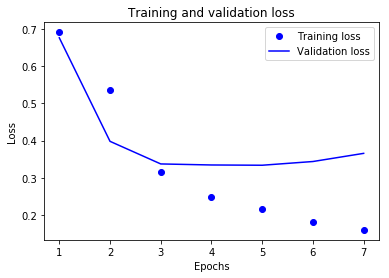

In [69]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

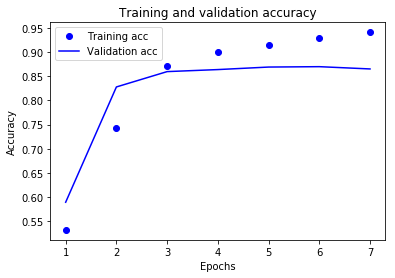

In [70]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()